In [208]:
day_obs = "20241104"

# Facilities Temperatures Reports
Author: Bruno C. Quint

This notebook contains a plot used to evaluate the safety of the M1M3 glass.
The temperature requirements are:
* The difference between the mirror cell and its surroundings must be below 5ºC. 
* The temperature increase/decrease rate must be less than 1ºC/h. 

The details about each topic are described below. 
Some of them might not be used in the current version.
However, I am leaving them here until this notebook gets mature and we reach an agreement on what needs monitoring. 


In [209]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import warnings

from astropy import units as u
from astropy.time import Time
from scipy.interpolate import interp1d
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData, getDayObsStartTime
from lsst.ts.xml.sal_enums import State


# Ignore the many warning messages from ``merge_packed_time_series``
warnings.simplefilter(action="ignore", category=FutureWarning)

# Create an EFD client
client = makeEfdClient()

# Constants used in the notebook
ess_weather_station_sal_index = 301
m1m3_inside_cell_sal_index = 113
dome_inside_sal_index = 111

# Create a folder for plots
os.makedirs("plots/", exist_ok=True)

## Query the data

In [210]:
day_obs = int(day_obs)
start_time = getDayObsStartTime(day_obs)
end_time = start_time + 1 * u.day

print(
    f"\nQuery data for {day_obs}"
    f"\n  starts at {start_time.isot} and"
    f"\n  ends at {end_time.isot}\n"
)


Query data for 20241104
  starts at 2024-11-04T12:00:00.000 and
  ends at 2024-11-05T12:00:00.000



The cell bellow contains data that comes from the Weather Station Tower.

In [211]:
df_outside = getEfdData(
    client=client,
    topic="lsst.sal.ESS.temperature",
    columns=["temperatureItem0", "salIndex", "location"],
    begin=start_time,
    end=end_time,
)

# Select the data from the weather station using the salIndex
mask = df_outside.salIndex == ess_weather_station_sal_index
df_outside = df_outside[mask]

# Print the location of this sensor
print("Sensor location: ", df_outside["location"].unique())

# We do not need the salIndex anymore
df_outside = df_outside.drop(columns=['salIndex'])

# Get the rolling min/mean/max values for the temperature
df_outside = df_outside.rename(columns={"temperatureItem0": "temperature"})
df_outside = df_outside.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_outside.columns = df_outside.columns.droplevel(0)

Sensor location:  ['Weather tower']


MTMount contains multiple temperature sensors near the telescope.  
For the sake of simplicity, we will monitor the temperature sensors near the 
Top End Assembly for now.

In [212]:
df_inside = getEfdData(
    client=client,
    topic="lsst.sal.MTMount.topEndChiller",
    columns=["ambientTemperature"],
    begin=start_time,
    end=end_time,
)

# Get the rolling min/mean/max values for the temperature
df_inside = df_inside.rename(columns={"ambientTemperature": "temperature"})
df_inside = df_inside.resample('1T').agg({
    'temperature': ['mean', 'min', 'max']
})
df_inside.columns = df_inside.columns.droplevel(0)

The telemetry above has not been reliable.  
As an attempt of investigating it a bit more, we can visualize what are the summary states of MTMount. 

In [213]:
df_mtmount = getEfdData(
    client=client,
    topic="lsst.sal.MTMount.logevent_summaryState",
    columns=["summaryState"],
    begin=start_time,
    end=end_time,
)

if df_mtmount.index.empty:
    df_mtmount = pd.DataFrame(columns=["summaryState"])

(add more information about Glycol cold)

In [214]:
df_glycol_cold = getEfdData(
    client=client,
    topic="lsst.sal.MTMount.cooling",
    columns=["glycolTemperaturePier0101"],
    begin=start_time,
    end=end_time,
)

df_glycol_cold = df_glycol_cold.rename(columns={"glycolTemperaturePier0101": "temperature"})
df_glycol_cold = df_glycol_cold.resample('1T').agg({
    'temperature': ['mean', 'min', 'max']
})
df_glycol_cold.columns = df_glycol_cold.columns.droplevel(0)

(add more information about Glycol General)

In [215]:
df_glycol_general = getEfdData(
    client=client,
    topic="lsst.sal.MTMount.generalPurposeGlycolWater",
    columns=["glycolTemperaturePier0001"],
    begin=start_time,
    end=end_time,
)

# Get the rolling min/mean/max values for the temperature
df_glycol_general = df_glycol_general.rename(columns={"glycolTemperaturePier0001": "temperature"})
df_glycol_general = df_glycol_general.resample('1T').agg({
    'temperature': ['mean', 'min', 'max']
})
df_glycol_general.columns = df_glycol_general.columns.droplevel(0)

The `df_m1m3` below represents the air above M1M3.  
We can use it as an estimate of the temperature inside the dome and near the cell. 

In [216]:
df_m1m3 = getEfdData(
    client=client,
    topic="lsst.sal.ESS.temperature",
    columns=["temperatureItem0", "salIndex", "location"],
    begin=start_time,
    end=end_time,
)

# Select the data from the weather station using the salIndex
mask = df_m1m3.salIndex == m1m3_inside_cell_sal_index
df_m1m3 = df_m1m3[mask]

# Print the location of this sensor
print("Sensor location: ", df_m1m3["location"].unique())

# We do not need the salIndex anymore
df_m1m3 = df_m1m3.drop(columns=['salIndex'])

# Get the rolling min/mean/max values for the temperature
df_m1m3 = df_m1m3.rename(columns={"temperatureItem0": "temperature"})
df_m1m3 = df_m1m3.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_m1m3.columns = df_m1m3.columns.droplevel(0)

Sensor location:  ['M1M3; RPi with sticker 4']


This is another measurement of the temperature inside the dome.  
We need more details about its location since the output is not clear. 

In [217]:
df_inside_dome = getEfdData(
    client=client,
    topic="lsst.sal.ESS.temperature",
    columns=["temperatureItem0", "salIndex", "location"],
    begin=start_time,
    end=end_time,
)

# Select the data from the weather station using the salIndex
mask = df_inside_dome.salIndex == dome_inside_sal_index
df_inside_dome = df_inside_dome[mask]

# Print the location of this sensor
print("Sensor location: ", df_inside_dome["location"].unique())

# We do not need the salIndex anymore
df_inside_dome = df_inside_dome.drop(columns=['salIndex'])

# Get the rolling min/mean/max values for the temperature
df_inside_dome = df_inside_dome.rename(columns={"temperatureItem0": "temperature"})
df_inside_dome = df_inside_dome.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_inside_dome.columns = df_inside_dome.columns.droplevel(0)

Sensor location:  ['Camera inlet plane; RPi with sticker 3']


The telemetry below retrieves the temperatures from inside the cell.  
There are 96 sensors in this topic.  
This is why the statistics are calculated across them intead of a rolling window. 

In [218]:
df_m1m3ts_inside = getEfdData(
    client=client,
    topic="lsst.sal.MTM1M3TS.thermalData",
    columns=[f"absoluteTemperature{i}" for i in range(96)],
    begin=start_time,
    end=end_time
)

df_m1m3ts_inside["mean"] = df_m1m3ts_inside.mean(axis=1)
df_m1m3ts_inside["min"] = df_m1m3ts_inside.min(axis=1)
df_m1m3ts_inside["max"] = df_m1m3ts_inside.max(axis=1)

The mixing valve allows glycol circulation within the cell.  
It ranges from 0% to 100% opened.  
The more it is opened, the more it will cool down the m1m3 cell. 

In [219]:
df_m1m3ts_mixing_valve = getEfdData(
    client=client,
    topic="lsst.sal.MTM1M3TS.mixingValve",
    columns=["valvePosition"],
    begin=start_time,
    end=end_time
)

This topic came from Petr and Sandrine as another estimate of the temperature inside the cell.  
The topic name and the documentation in the ts-xml page confirms that.  
It is not clear if it has any special spatial distribution that can be relevant in the analysis.

In [220]:
df_m1m3ts_glycol_loop = getEfdData(
    client=client,
    topic="lsst.sal.MTM1M3TS.glycolLoopTemperature",
    columns=[f"insideCellTemperature{i}" for i in range(1, 4)],
    begin=start_time,
    end=end_time
)

df_m1m3ts_glycol_loop_1 = pd.DataFrame(df_m1m3ts_glycol_loop["insideCellTemperature1"])
df_m1m3ts_glycol_loop_1 = df_m1m3ts_glycol_loop_1.rename(columns={"insideCellTemperature1": "temperature"})
df_m1m3ts_glycol_loop_1 = df_m1m3ts_glycol_loop_1.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_m1m3ts_glycol_loop_1.columns = df_m1m3ts_glycol_loop_1.columns.droplevel(0)

df_m1m3ts_glycol_loop_2 = pd.DataFrame(df_m1m3ts_glycol_loop["insideCellTemperature2"])
df_m1m3ts_glycol_loop_2 = df_m1m3ts_glycol_loop_2.rename(columns={"insideCellTemperature2": "temperature"})
df_m1m3ts_glycol_loop_2 = df_m1m3ts_glycol_loop_2.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_m1m3ts_glycol_loop_2.columns = df_m1m3ts_glycol_loop_2.columns.droplevel(0)

df_m1m3ts_glycol_loop_3 = pd.DataFrame(df_m1m3ts_glycol_loop["insideCellTemperature3"])
df_m1m3ts_glycol_loop_3 = df_m1m3ts_glycol_loop_3.rename(columns={"insideCellTemperature3": "temperature"})
df_m1m3ts_glycol_loop_3 = df_m1m3ts_glycol_loop_3.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_m1m3ts_glycol_loop_3.columns = df_m1m3ts_glycol_loop_3.columns.droplevel(0)

In [221]:
df_m2 = getEfdData(
    client=client,
    topic="lsst.sal.ESS.temperature",
    columns=["temperatureItem0", "salIndex", "location"],
    begin=start_time,
    end=end_time
)

# Select the data from the weather station using the salIndex
mask = df_m2.salIndex == 112
df_m2 = df_m2[mask]

# Print the location of this sensor
print("Sensor location: ", df_m2["location"].unique())

# We do not need the salIndex anymore
df_m2 = df_m2.drop(columns=['salIndex'])

# Get the rolling min/mean/max values for the temperature
df_m2 = df_m2.rename(columns={"temperatureItem0": "temperature"})
df_m2 = df_m2.resample("1min").agg(
    {"temperature": ["min", "mean", "max"]}
)
df_m2.columns = df_m2.columns.droplevel(0)

Sensor location:  ['M2; RPi with sticker 1']


In [222]:
count = 336
fields = ["timestamp", "temperature", "temperatureSpread"]

df_weather_forecast = getEfdData(
    client=client,
    topic="lsst.sal.WeatherForecast.hourlyTrend",
    columns=[f"{field}{i}" for field, i in itertools.product(fields, range(count))],
    begin=start_time,
    end=end_time
)

# This will be published near 23:34 UTC
s_weather_forecast = df_weather_forecast.iloc[0]

weather_forecast_update_date = s_weather_forecast.name

timestamps = Time(s_weather_forecast[[f"timestamp{i}" for i in range(count)]], format="unix", scale="utc").isot
timestamps = pd.to_datetime(timestamps)
temperatures = s_weather_forecast[[f"temperature{i}" for i in range(count)]]
temperatures_spread = s_weather_forecast[[f"temperatureSpread{i}" for i in range(count)]]

df_weather_forecast = pd.DataFrame(
    np.array([temperatures, temperatures_spread]).T,
    columns=["temperature", "temperatureSpread"],
    index=timestamps
)

# df = df_weather_forecast.set_index("timestamp")
df = df[(df.index >= start_time) & (df.index <= end_time)]
df["temperature"] = pd.to_numeric(df["temperature"])
df["temperatureSpread"] = pd.to_numeric(df["temperatureSpread"])

df["mean"] = df["temperature"]
df["min"] = df["temperature"] - 0.5 * np.array(df["temperatureSpread"])
df["max"] = df["temperature"] + 0.5 * np.array(df["temperatureSpread"])

df_weather_forecast = df

TypeError: Invalid comparison between dtype=datetime64[ns] and Time

In [35]:
start_time.datetime
#df_weather_forecast.index

datetime.datetime(2024, 11, 3, 12, 0)

## Temperatures Plots 

For each plot we have a solid line representing the rolling average per minute. 
In addition, the figure below contains a shaded region per color showing the min/max 
values per telemetry. However, since the min/max values do not stray far from the 
average, they are almost imperceptible.

In [223]:
def plot_temperature(ax, df, label, color, alpha=0.5):
    """
    Add a new plot to the axes with the mean temperature
    and the min/max fill_between.

    Parameters
    ----------
    ax : matplotlib.pyplot.Axes
        Axes that will hold the plot.
    df : pandas.DataFrame
        Dataframe containing the `mean`, `min`, `max` columns.
    label : str
        A string to add to the legend.
    color : str
        A string representing the color of the plots.
    alpha : float
        A float representing the transparency of the fill_between.
    """
    ax.plot(
        df.index,
        df["mean"],
        label=label,
        color=color
    )
    ax.fill_between(
        df.index,
        df["min"],
        df["max"],
        color=color,
        alpha=alpha
    )

In [256]:
def evaluate_data(m1m3_temp_df, outside_temp_df):
    """
    Makes some calculations on the temperature data, evaluating if 
    temperature difference between M1M3 and outside temperature and 
    the rate of change.

    Also evaluates the Risk:
    low(0): temp_diff < 4 C OR hour_time_change <0.7 deg/hour
    warning(1): 4 < temp_diff < 5 C OR 0.7 < hour_time_change <1 deg/hour
    critical(2): temp_diff > 5 OR hour_time_change > 1 deg/hour

    Parameters
    ----------
    m1m3_temp_df : pandas.DataFrame
        The data you want to use that signifies the M1M3 data
    outside_temp_df : pandas.DataFrame
        The data you want to use that signifies the Outside temperature

    Returns
    -------
    m1m3_temp_df.index : list
        Time to plot against the Temperature Difference and Hourly Rate of Change
    temp_diff : list 
        Temperature Difference between M1M3 and the outside temperature
    hour_time_change : list
        Hourly Rate of Change of M1M3
    risk : int
        Risk Level as defined above
    """
    # Interpolate data streams to determine temperature difference
    m1m3_time = m1m3_temp_df.index.astype('int') / 1e-9
    outside_time = outside_temp_df.index.astype('int') / 1e-9
    m1m3_temp = interp1d(m1m3_time, m1m3_temp_df['mean'], bounds_error=False, fill_value="extrapolate")
    outside_temp = interp1d(outside_time, outside_temp_df['mean'], bounds_error=False, fill_value='extrapolate')
    temp_diff = m1m3_temp(m1m3_time) - outside_temp(m1m3_time)

    # Calculate the hourly rate of change
    # need to determine how many periods makes up an hour
    total_time = m1m3_temp_df.index[-1] - m1m3_temp_df.index[0]
    spacing = total_time/len(m1m3_temp_df)
    period = pd.Timedelta(hours=1)/spacing

    prev_temp = m1m3_temp_df.shift(periods=np.floor(period))
    hour_time_change = prev_temp['mean']-m1m3_temp_df['mean']

    # Evaluate the Risk
    if temp_diff[-1] < 4 :
        risk = 0
    elif (temp_diff[-1] > 4) | (temp_diff[-1] < 5):
        risk = 1
    elif temp_diff[-1] > 5:
        risk = 2

    if hour_time_change[-1] < 0.7:
        risk2 = 0
    elif (hour_time_change[-1] > 0.7) & (hour_time_change[-1] < 1):
        risk2 = 1
    elif hour_time_change[-1] > 1:
        risk2 = 2
    return m1m3_temp_df.index, list(temp_diff), list(hour_time_change), max(risk, risk2)
time_plot, temp_diff, rate_change, risk = evaluate_data(df_m1m3, df_outside)

TypeError: slice indices must be integers or None or have an __index__ method

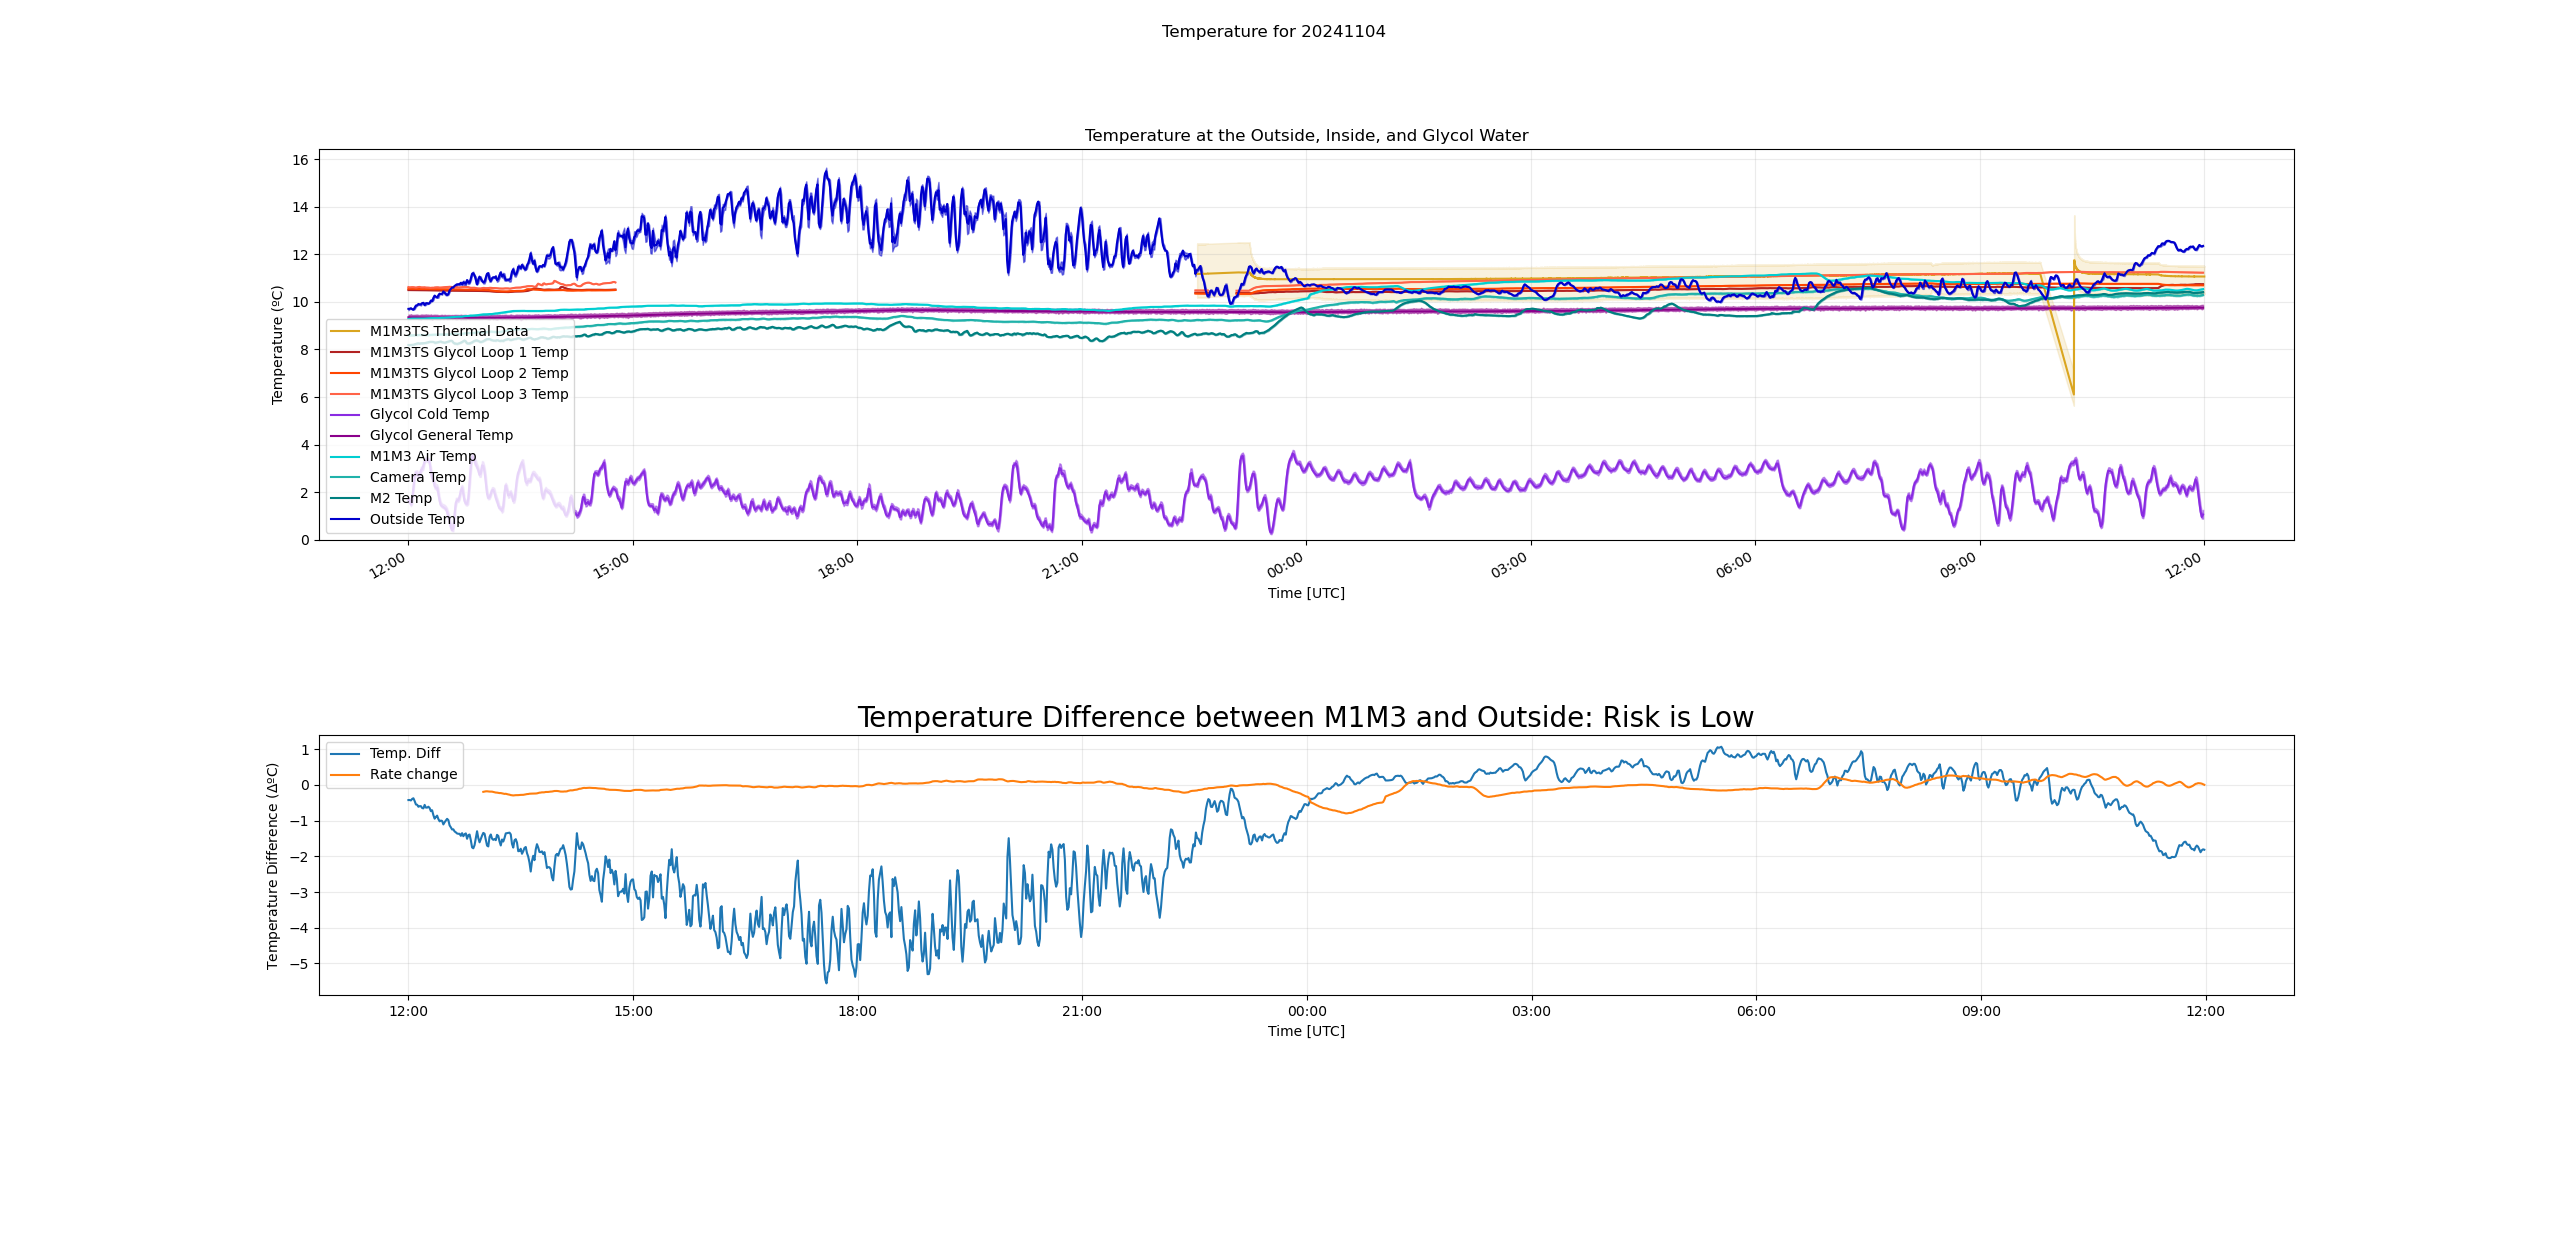

In [237]:
#%matplotlib widget

fig.clear()
fig = plt.figure(figsize=(15,15), num=f"temperatures_{day_obs}")
gs = fig.add_gridspec(2, 1, hspace=0.6, height_ratios=[6,4])
ax = fig.add_subplot(gs[0])
plot_temperature(ax, df_m1m3ts_inside, label="M1M3TS Thermal Data", color="goldenrod", alpha=0.15)
plot_temperature(ax, df_m1m3ts_glycol_loop_1, label="M1M3TS Glycol Loop 1 Temp", color="firebrick")
plot_temperature(ax, df_m1m3ts_glycol_loop_2, label="M1M3TS Glycol Loop 2 Temp", color="orangered")
plot_temperature(ax, df_m1m3ts_glycol_loop_3, label="M1M3TS Glycol Loop 3 Temp", color="tomato")
plot_temperature(ax, df_glycol_cold, label="Glycol Cold Temp", color="blueviolet")
plot_temperature(ax, df_glycol_general, label="Glycol General Temp", color="darkmagenta")
plot_temperature(ax, df_m1m3, label="M1M3 Air Temp", color="darkturquoise")
plot_temperature(ax, df_inside_dome, label="Camera Temp", color="lightseagreen")
plot_temperature(ax, df_m2, label="M2 Temp", color="teal")
plot_temperature(ax, df_outside, label="Outside Temp", color="mediumblue")
# plot_temperature(ax, df_weather_forecast, label=f"Weather Forecase - {weather_forecast_update_date}", color="mediumblue")

## The following line is commented out because the data is not reliable
# add_plot(ax, df_inside, label="Inside Temp", color="brown")

fig.suptitle(f"Temperature for {day_obs}")
fig.autofmt_xdate()

ax.grid(":", alpha=0.25)
ax.legend(loc="lower left")
ax.set_title("Temperature at the Outside, Inside, and Glycol Water")
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Temperature (ºC)')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
y_min, ymax = ax.get_ylim()
ax.set_ylim(max(0, y_min), ymax)

## Get evaluation data
risk_label = {0:'Low', 1:'Warning', 2:'Critical'}
time_plot, temp_diff, rate_change, risk = evaluate_data(df_m1m3, df_outside)
ax2 = fig.add_subplot(gs[1])
ax2.grid(":", alpha=0.25)
ax2.plot(time_plot, temp_diff, label='Temp. Diff')
ax2.plot(time_plot, rate_change, label='Rate change')
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Temperature Difference ($\Delta$ºC)')
ax2.set_title(f"Temperature Difference between M1M3 and Outside: Risk is {risk_label[risk]}", fontsize=20)
ax2.legend()

plt.savefig(f"./plots/temperature_outside_{day_obs}.png")
plt.show()


## Hourly statistics

Here we have a table per topic with the min/mean/max value every hour. 

In [44]:
def print_dataframe(df):
    """
    Print the first and last 5 rows of the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to print.
    """
    datetime_format = '%Y-%m-%d %H:%M UTC'

    # Resample each data frame to hourly frequencay
    df = df.resample('H').nearest()

    # Change the format of the index to include only year, month, day, hour, and minute
    df.index = df.index.strftime(datetime_format)

    # Round the temperature values to two decimal places
    df = df.round(2)

    print(df)

In [45]:
print_dataframe(df_outside)

                        min   mean    max
2024-11-03 12:00 UTC   9.75   9.79   9.82
2024-11-03 13:00 UTC  10.27  10.37  10.52
2024-11-03 14:00 UTC  10.02  10.08  10.18
2024-11-03 15:00 UTC  10.95  11.02  11.07
2024-11-03 16:00 UTC  11.88  12.02  12.15
2024-11-03 17:00 UTC  11.40  11.52  11.75
2024-11-03 18:00 UTC  11.75  11.99  12.11
2024-11-03 19:00 UTC  11.43  11.75  12.27
2024-11-03 20:00 UTC  11.23  11.48  11.85
2024-11-03 21:00 UTC  10.35  10.43  10.50
2024-11-03 22:00 UTC   7.40   7.74   7.97
2024-11-03 23:00 UTC   7.70   7.74   7.78
2024-11-04 00:00 UTC   8.32   8.34   8.38
2024-11-04 01:00 UTC   6.65   6.68   6.70
2024-11-04 02:00 UTC   7.55   7.58   7.60
2024-11-04 03:00 UTC   7.88   7.89   7.93
2024-11-04 04:00 UTC   7.60   7.60   7.62
2024-11-04 05:00 UTC   7.10   7.13   7.15
2024-11-04 06:00 UTC   7.32   7.38   7.43
2024-11-04 07:00 UTC   7.35   7.36   7.38
2024-11-04 08:00 UTC   6.97   7.00   7.00
2024-11-04 09:00 UTC   7.05   7.09   7.15
2024-11-04 10:00 UTC   7.20   7.23

In [46]:
print_dataframe(df_m1m3)

                        min   mean    max
2024-11-03 12:00 UTC  11.24  11.24  11.25
2024-11-03 13:00 UTC  11.25  11.25  11.25
2024-11-03 14:00 UTC  11.25  11.25  11.25
2024-11-03 15:00 UTC  11.25  11.25  11.25
2024-11-03 16:00 UTC  11.25  11.26  11.26
2024-11-03 17:00 UTC  11.05  11.05  11.05
2024-11-03 18:00 UTC  10.98  10.98  10.98
2024-11-03 19:00 UTC  10.94  10.94  10.94
2024-11-03 20:00 UTC  10.88  10.88  10.89
2024-11-03 21:00 UTC  10.84  10.85  10.85
2024-11-03 22:00 UTC  10.76  10.76  10.77
2024-11-03 23:00 UTC  10.70  10.70  10.71
2024-11-04 00:00 UTC  10.35  10.35  10.36
2024-11-04 01:00 UTC  10.07  10.07  10.08
2024-11-04 02:00 UTC   9.63   9.64   9.65
2024-11-04 03:00 UTC   8.73   8.73   8.73
2024-11-04 04:00 UTC   9.29   9.30   9.30
2024-11-04 05:00 UTC   9.54   9.55   9.55
2024-11-04 06:00 UTC   9.55   9.55   9.56
2024-11-04 07:00 UTC   9.16   9.17   9.19
2024-11-04 08:00 UTC   9.11   9.11   9.12
2024-11-04 09:00 UTC   9.28   9.29   9.30
2024-11-04 10:00 UTC   9.25   9.26

In [47]:
print_dataframe(df_inside_dome)

                        min   mean    max
2024-11-03 12:00 UTC  10.49  10.52  10.54
2024-11-03 13:00 UTC  10.50  10.52  10.54
2024-11-03 14:00 UTC  10.51  10.53  10.55
2024-11-03 15:00 UTC  10.55  10.57  10.59
2024-11-03 16:00 UTC  10.56  10.58  10.60
2024-11-03 17:00 UTC  10.40  10.42  10.44
2024-11-03 18:00 UTC  10.33  10.36  10.38
2024-11-03 19:00 UTC  10.24  10.27  10.30
2024-11-03 20:00 UTC  10.19  10.21  10.24
2024-11-03 21:00 UTC  10.13  10.16  10.19
2024-11-03 22:00 UTC  10.01  10.04  10.07
2024-11-03 23:00 UTC   9.88   9.91   9.93
2024-11-04 00:00 UTC   9.88   9.91   9.93
2024-11-04 01:00 UTC   9.36   9.38   9.39
2024-11-04 02:00 UTC   9.17   9.18   9.19
2024-11-04 03:00 UTC   9.39   9.41   9.42
2024-11-04 04:00 UTC   9.01   9.03   9.04
2024-11-04 05:00 UTC   8.82   8.84   8.86
2024-11-04 06:00 UTC   8.65   8.67   8.68
2024-11-04 07:00 UTC   8.65   8.66   8.67
2024-11-04 08:00 UTC   8.54   8.55   8.57
2024-11-04 09:00 UTC   8.47   8.49   8.50
2024-11-04 10:00 UTC   8.43   8.45

In [48]:
print_dataframe(df_m1m3ts_inside.mean(axis=1))

2024-11-03 17:00 UTC     9.24
2024-11-03 18:00 UTC    12.68
2024-11-03 19:00 UTC    12.91
2024-11-03 20:00 UTC    12.98
2024-11-03 21:00 UTC    12.91
2024-11-03 22:00 UTC    12.90
2024-11-03 23:00 UTC    12.85
2024-11-04 00:00 UTC    12.81
2024-11-04 01:00 UTC    12.03
2024-11-04 02:00 UTC    11.89
2024-11-04 03:00 UTC    11.78
2024-11-04 04:00 UTC    11.85
2024-11-04 05:00 UTC    11.79
2024-11-04 06:00 UTC    11.72
2024-11-04 07:00 UTC    11.66
2024-11-04 08:00 UTC    11.60
dtype: float64


In [49]:
print_dataframe(df_m1m3ts_glycol_loop_1)

                        min   mean    max
2024-11-03 17:00 UTC  11.62  11.63  11.63
2024-11-03 18:00 UTC  11.62  11.62  11.62
2024-11-03 19:00 UTC  11.60  11.60  11.60
2024-11-03 20:00 UTC  11.59  11.59  11.59
2024-11-03 21:00 UTC  11.31  11.31  11.31
2024-11-03 22:00 UTC  11.26  11.26  11.26
2024-11-03 23:00 UTC  11.19  11.19  11.19
2024-11-04 00:00 UTC  11.13  11.13  11.13
2024-11-04 01:00 UTC  11.29  11.29  11.29
2024-11-04 02:00 UTC  11.24  11.24  11.24
2024-11-04 03:00 UTC  11.12  11.13  11.13
2024-11-04 04:00 UTC  10.96  10.96  10.97
2024-11-04 05:00 UTC  10.84  10.84  10.84
2024-11-04 06:00 UTC  10.74  10.74  10.74
2024-11-04 07:00 UTC  10.64  10.64  10.64
2024-11-04 08:00 UTC  10.57  10.57  10.57
2024-11-04 09:00 UTC  10.68  10.68  10.68
2024-11-04 10:00 UTC  10.59  10.59  10.59
2024-11-04 11:00 UTC  10.55  10.55  10.55


In [50]:
print_dataframe(df_m1m3ts_glycol_loop_2)

                        min   mean    max
2024-11-03 17:00 UTC  11.61  11.61  11.61
2024-11-03 18:00 UTC  11.60  11.60  11.61
2024-11-03 19:00 UTC  11.58  11.58  11.58
2024-11-03 20:00 UTC  11.57  11.57  11.57
2024-11-03 21:00 UTC  11.44  11.44  11.44
2024-11-03 22:00 UTC  11.41  11.41  11.41
2024-11-03 23:00 UTC  11.36  11.36  11.36
2024-11-04 00:00 UTC  11.32  11.32  11.32
2024-11-04 01:00 UTC  11.43  11.43  11.43
2024-11-04 02:00 UTC  11.36  11.36  11.36
2024-11-04 03:00 UTC  11.26  11.27  11.27
2024-11-04 04:00 UTC  11.16  11.16  11.16
2024-11-04 05:00 UTC  11.09  11.09  11.09
2024-11-04 06:00 UTC  11.00  11.00  11.00
2024-11-04 07:00 UTC  10.93  10.93  10.93
2024-11-04 08:00 UTC  10.87  10.87  10.87
2024-11-04 09:00 UTC  10.78  10.79  10.79
2024-11-04 10:00 UTC  10.67  10.67  10.67
2024-11-04 11:00 UTC  10.61  10.61  10.61


In [51]:
print_dataframe(df_m1m3ts_glycol_loop_3)

                        min   mean    max
2024-11-03 17:00 UTC  11.79  11.79  11.79
2024-11-03 18:00 UTC  11.78  11.78  11.78
2024-11-03 19:00 UTC  11.76  11.76  11.76
2024-11-03 20:00 UTC  11.74  11.74  11.74
2024-11-03 21:00 UTC  11.97  11.97  11.97
2024-11-03 22:00 UTC  11.99  11.99  11.99
2024-11-03 23:00 UTC  12.01  12.01  12.01
2024-11-04 00:00 UTC  11.99  11.99  11.99
2024-11-04 01:00 UTC  12.06  12.06  12.07
2024-11-04 02:00 UTC  12.00  12.00  12.00
2024-11-04 03:00 UTC  11.88  11.88  11.88
2024-11-04 04:00 UTC  11.77  11.77  11.77
2024-11-04 05:00 UTC  11.73  11.73  11.74
2024-11-04 06:00 UTC  11.69  11.69  11.70
2024-11-04 07:00 UTC  11.64  11.65  11.65
2024-11-04 08:00 UTC  11.58  11.58  11.58
2024-11-04 09:00 UTC  11.05  11.06  11.06
2024-11-04 10:00 UTC  10.89  10.89  10.90
2024-11-04 11:00 UTC  10.76  10.77  10.77
